# Optimization Problem

The optimization problem can be written as:

$$
\text{min} \quad \sum_{t} \left( r x_t + q u_t \right)
$$

Subject to the following constraints:

$$
u_t + k s_t = G_t \quad \forall t \quad \text{(Demand constraint)}
$$

$$
c_{t+1} = c_t + s_t \quad \forall t \quad \text{(Storage evolution)}
$$

$$
c_T = c_0 \quad \text{(Final charge constraint)}
$$

$$
x_{t+1} = x_t + L_t - u_t \quad \forall t \quad \text{(Workload evolution)}
$$


$$
x_T = 0 \quad \text{(Backlog clearance)}
$$

$$
x_t, c_t, u_t \geq 0 \quad \forall t \quad \text{(Non-negativity)}
$$


Where:
- \( x_t \): backlog or deferred workload at time \( t \)
- \( u_t \): amount of workload processed at time \( t \)
- \( r \): cost per unit of backlog — penalizes unprocessed/delayed work
- \( q \): cost per unit of processing — energy, labor, or other operational costs
- \( L_t \): new workload arriving at time \( t \)


## Constraints

### Demand Constraint:
$$
u_t + k s_t = G_t \quad \forall t
$$

Where:
- \( G_t \): power consumption (e.g., grid energy) at time \( t \)
- \( s_t \): power stored into battery at time \( t \)
- \( k \): conversion factor between storage and power (e.g., efficiency)

### Storage Evolution:
$$
c_{t+1} = c_t + s_t \quad \forall t
$$

### Final Charge Constraint:
$$
c_T = c_0
$$

### Workload Evolution:
$$
x_{t+1} = x_t + L_t - u_t \quad \forall t
$$

Where:
- \( L_t \): new workload arriving at time \( t \)

### Backlog Clearance:
$$
x_T = 0
$$

### Non-Negativity:
$$
x_t \geq 0, \quad c_t \geq 0, \quad u_t \geq 0 \quad \forall t
$$

## Summary
This linear program determines:
- Workload processing decisions (\( u_t \))
- Energy usage and storage (\( s_t \), \( c_t \))
- Backlog management (\( x_t \))

All while minimizing the total cost from both deferred (\( r x_t \)) and completed work (\( q u_t \)), under operational and physical constraints.


# Incorporating Cooling

We assume that all electricity used for computing purposes is generated into heat, and the heat removed/cooled is the same as the heat generated:

$$
\dot{Q}_{load} = \dot{W}_{computing} = \dot{Q}_{cooling}
$$

Thus, 
$$
P_{chiller}(t) = \frac{\dot{Q}_{cooling}(t)}{COP(T_{ambient}(t))}
$$

From literature (Yu 2005 and Zhang 2024), we determine a relationship between COP and ambient temperature:
$$
COP(T_{ambient}(t)) = COP_{ref} \cdot (1-0.02(T_{ambient} - T_{ref}))
$$

# Defining Costs
## Backlog Cost
Assigning a monetary cost to backlog measured in megawatt-hours (MWh) requires careful consideration of various factors, including revenue loss, SLA penalties, and operational impacts.
Let's say it's $50/MWh

In [ ]:
import pandas as pd
workload_path = "data/Workload/GoogleClusteData_CPU_Data_Hourly_1.csv"
renewable_path = "data/CarbonIntensity/CAISO_NG_&_avgCI.csv"
workload = pd.read_csv(workload_path)
renewable_gen = pd.read_csv(renewable_path)
workload.head()
Load = workload["cpu_load"]*100
caiso_wind_cap = 6284
DC_wind_cap = 120
Carbon_intensity = renewable_gen["avg_CI"].to_list()
caiso_wind_gen = renewable_gen["WND"]
DC_wind_gen = (caiso_wind_gen/caiso_wind_cap)*DC_wind_cap
T = 5
# G = DC_wind_gen.round()
G = DC_wind_gen.fillna(0).astype(int).to_list()


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Input data (already loaded from previous context)
# Parameters
q = 1.0  # Cost per unit energy used
r = 200  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit =100 # float("inf") #or switch to actual computing limit
battery_limit = 300 # float("inf") # or switch to actual computing limit
# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
L = [
    30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 
    55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
]  # Computational Load sum = 1400
G = [
     0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
   143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
]  #Renewable Generation sum = 1526

T = len(G)



def shift_from_utc(data, offset_hours):
    """
    Shift a list of 24 hourly values from UTC to a timezone that is `offset_hours`
    behind UTC.

    """
    if len(data) != 24:
        raise ValueError(f"Expected 24 hourly values, got {len(data)}")
    # roll left by offset_hours:
    k = offset_hours % 24
    return data[k:] + data[:k]


# Plotting helper function for each scenario
def plot_results(title, served, soc=None, second_plot=None, backlog=None,
                 carbon_intensity=None, emissions=None):
    
    
    total_demand = sum(L)
    total_served = sum(served)
    total_emissions = sum(emissions) if emissions else None

    # Collect secondary plots
    secondary_plots = []
    if second_plot: secondary_plots.append(('Generation Over Time', G, 'Power (kW)', 'green'))
    if soc: secondary_plots.append(('Battery State of Charge', soc, 'Stored Energy (% of Capacity)', 'purple'))
    if backlog: secondary_plots.append(('Backlog Over Time', backlog, 'Energy(MW)', 'crimson'))
    if carbon_intensity: secondary_plots.append(('Carbon Intensity Over Time', carbon_intensity, 'kg CO₂ / MWh', 'gray'))
    if emissions: secondary_plots.append(('Emissions Over Time', emissions, 'kg CO₂', 'black'))
    
    num_rows = 1 + len(secondary_plots)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, 4 * num_rows), squeeze=False)

    # Plot 1: Load and Served
    ax_main = axs[0, 0]
    ax_main.plot(range(len(L)), L, marker="o", label="Load (Demand, MW)", color="blue")
    ax_main.plot(range(len(served)), served, marker="o", label="Served", color="orange")
    ax_main.fill_between(range(len(L)), 0, L, alpha=0.1, color="blue")
    ax_main.fill_between(range(len(served)), 0, served, alpha=0.2, color="orange")
    ax_main.set_title(title)
    ax_main.set_xlabel("Time Step")
    ax_main.set_ylabel("Energy")
    ax_main.grid(True)
    ax_main.legend()

    text = f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}"
    if total_emissions is not None:
        text += f"\nTotal Emissions = {total_emissions:.1f} kgCO₂"
    ax_main.text(len(L) - 2, max(max(L), max(served)) * 0.85,
                text, bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # Plot each additional element in its own row
    for i, (title_i, data_i, y_label, color) in enumerate(secondary_plots, start=1):
        ax = axs[i, 0]
        ax.plot(range(len(data_i)), data_i, marker='o', color=color, label=title_i)
        ax.fill_between(range(len(data_i)), 0, data_i, color=color, alpha=0.15)
        ax.set_title(title_i)
        ax.set_xlabel("Time Step")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()
    
   

C = shift_from_utc(Carbon_intensity[:T], 8)  # Shift to PST (UTC-8)




Deferal of elecrtricity for workload schedule, look for interesting ranges, 
Regime changes, where we switch from storage to workload to storage.
Find an analytical solution
Leave cost of load shifting as a variable,

Cost of load shifting is taken care of backlog, 

Add an innefiency to discahrge c, for analytical solution, once we have everything go through and replace with eta and make it all works. help us the regime shift between load shifting and storage. For computaiton we can leave eta as is, for charge and discharge

From this first pass on the ACDC, we can see numerically that Job scheduling and storage complement each other as hypothesized by result of solving the optimal dual variables: check notes.
Indeed, in scenario 3, where we only had storage, we had to store 488 MW, to serve 1158 MW of load. In scenario 2, where we only schedule jobs, we serve 797 had a final backlog of, 500, the sum of all backlogs at 3435 (area under the curve), and the max backlog 508.
When we combine both we are able to meet the same demand of 1158, max stored amount 361 (-127 MW), and max backlog 330 (-178), total backlog 2249 (-1200?), and final backlog of 150 (-350).
Interestingly enough, if we introduce a maximum computational ability, it doesn't change our results that much.

In both cases, we still can't meet the entire demand, which is surprising to me since total generation surpasses ask in OH, we would need to have a lot more storage and renewable production for that to happen. But we try another alternative, to incorporate the grid.

# Grid with Storage & Workload Scheduling - No Renewables

For a Grid Reliant DC located in San Jose, CA, the NREL REopt Tool recommends we build a 3.086 MW battery with 4.07 MWh of capacity.


Optimal Schedule for Scenario 1:


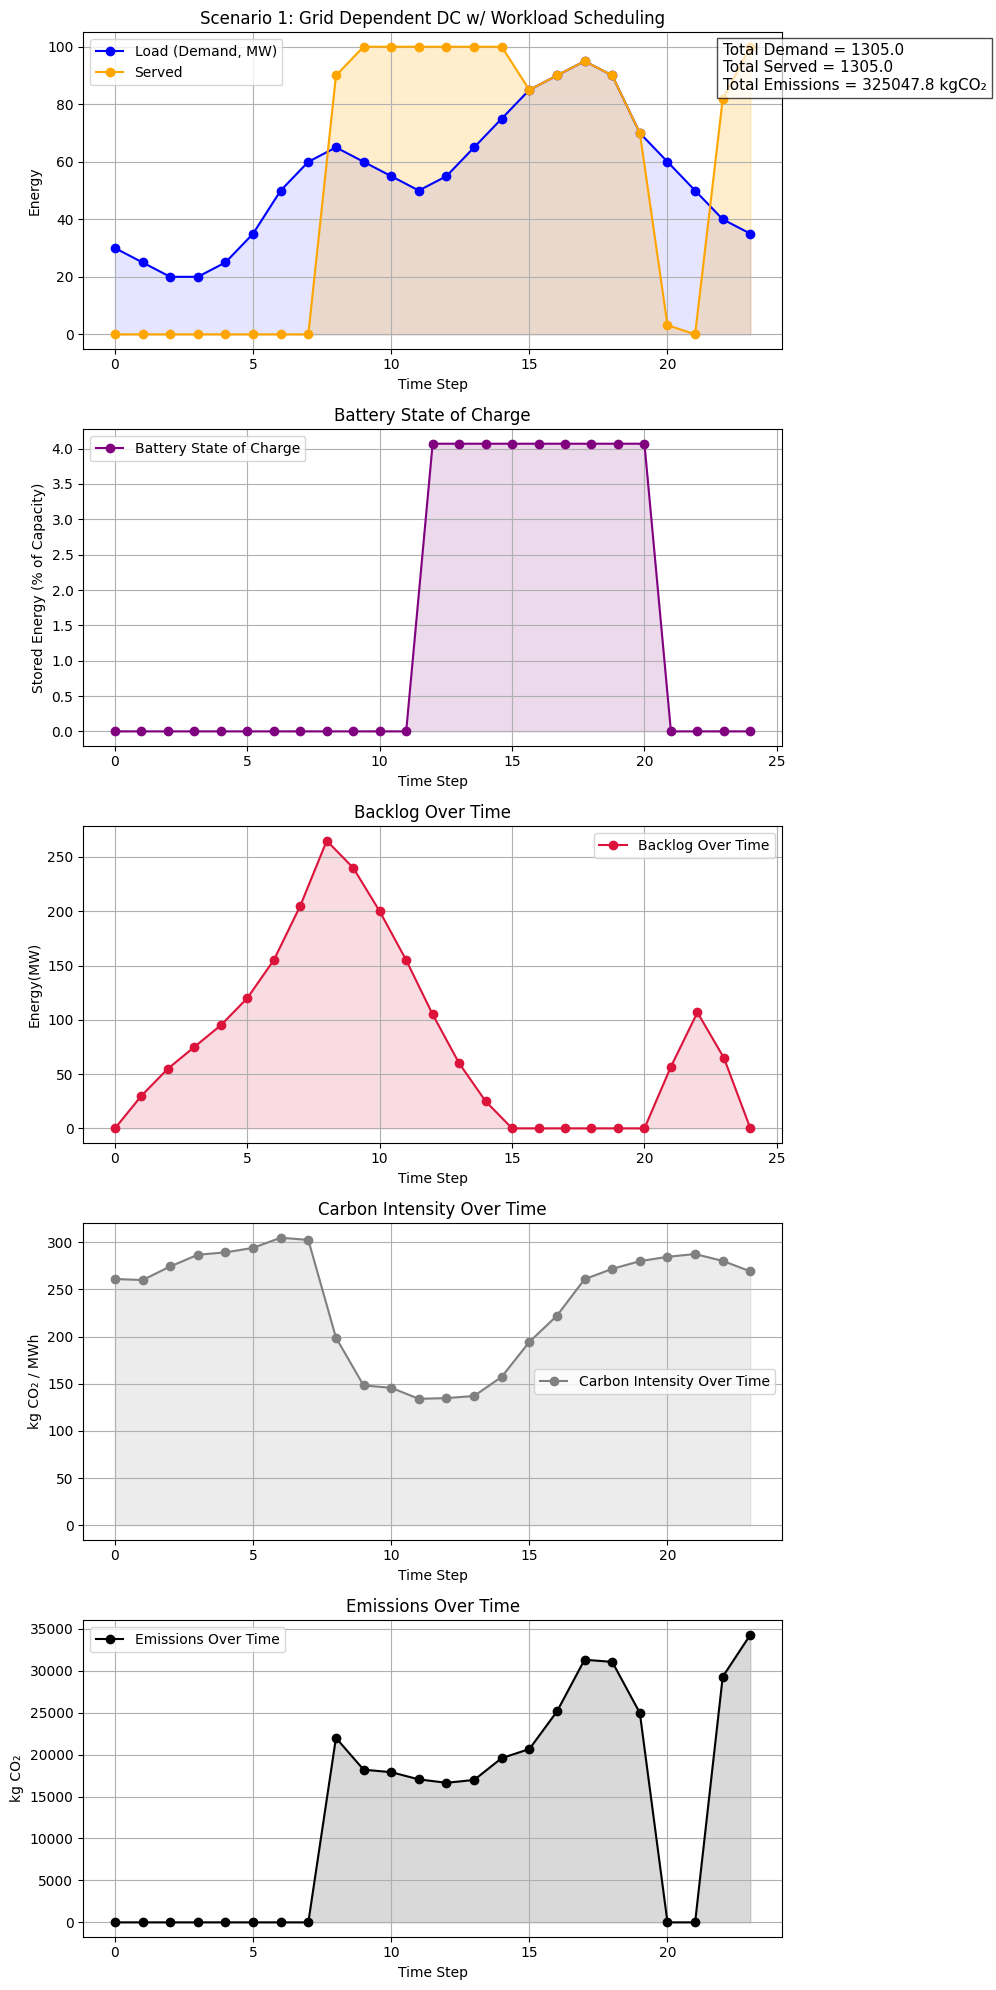

In [32]:

# Assume all demand is served by the grid

# Parameters
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = 4.07 # float("inf") # or switch to actual computing limit


hours = np.arange(T)             
T_ref, COP_ref = 25.0, 4.0
T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m1 = gp.Model("Grid + Storage w/ Optimal Scheduling")
m1.setParam("OutputFlag",0)

u_g = m1.addVars(T,name= "u_g",lb=0) # power associated with grid use
s_charge_g = m1.addVars(T,name="s_charge_g",lb=0) # charge associated with grid
s_discharge = m1.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m1.addVars(T+1,name="x",lb=0) # Backlog
c = m1.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m1.addVars(T, name="P_chiller", lb=0) # cooling load
u = m1.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m1.addConstr(x[0]==0,"initial backlog")
m1.addConstr(c[0]==0,"inital storage")

#Terminal Conditions
m1.addConstr(c[T] >= 0, "terminal_storage")
m1.addConstr(x[T] <= x[0], "terminal_backlog") 

# Dynamics and constraints
m1.addConstrs((c[t+1] == c[t] + s_charge_g[t] - s_discharge[t] for t in range(T)), name="soc_update")
m1.addConstrs((c[t+1] <= battery_limit for t in range(T)), name="storage_capacity")
m1.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name="max_discharge")
m1.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m1.addConstrs((u[t] <= 100 for t in range(T)),name="compute_limit")
m1.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m1.addConstrs((u_g[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_g[t] for t in range(T)), name="energy_balance")




m1.setObjective(gp.quicksum(u_g[t]*C[t] + r*x[t] for t in range(T)), GRB.MINIMIZE)
m1.optimize()


if m1.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 1:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    served_1 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_1 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_1 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_1 = [u_g[t].X * C[t] for t in range(T)]

    plot_results("Scenario 1: Grid Dependent DC w/ Workload Scheduling", served_1, soc=soc_1, backlog = backlog_1, carbon_intensity=C, emissions=emissions_1)








Add the Social cost of carbon, 50 dollars per ton, cost of electricity (static of dynamic)

Here, we see work scheduling utilizes storage to draw from the grid during low carbon intensity periods and meet the demand when the carbon intensity is higher (evening).

# Fully Grid Independent

In [ ]:
# Parameters
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = 10000 # float("inf") # or switch to actual computing limit
# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
L = [
    30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 
    55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
]  # Computational Load sum = 1400
G = [
     0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
   143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
]  #Renewable Generation sum = 1526

T = len(G)



hours = np.arange(T)             
T_ref, COP_ref = 25.0, 4.0
T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m2 = gp.Model("Cooling + Grid + Storage + Renewables Optimal Scheduling")
m2.setParam("OutputFlag",0)

u_r = m2.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m2.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
s_discharge = m2.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m2.addVars(T+1,name="x",lb=0) # Backlog
c = m2.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m2.addVars(T, name="P_chiller", lb=0) # cooling load
u = m2.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m2.addConstr(x[0]==0,"initial backlog")
m2.addConstr(c[0]==200,"inital storage")

#Terminal Conditions
m2.addConstr(c[T] >= 100, "terminal_storage")
m2.addConstr(x[T] <= x[0], "terminal_backlog") 

# Dynamics and constraints
m2.addConstrs((c[t+1] == c[t] + s_charge_r[t] - s_discharge[t] for t in range(T)), name="soc_update")
m2.addConstrs((c[t+1] <= battery_limit for t in range(T)), name="storage_capacity")
m2.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name="max_discharge")
m2.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m2.addConstrs((u[t] <= 100 for t in range(T)),name="compute_limit")
m2.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m2.addConstrs((u_r[t] + s_charge_r[t] == G[t] for t in range(T)),name="renewables_balance")
m2.addConstrs((u_r[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_r[t] for t in range(T)), name="energy_balance")




m2.setObjective(gp.quicksum(r*x[t] for t in range(T)), GRB.MINIMIZE)
m2.optimize()


if m2.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 2:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    served_2 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_2 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_2 = [x[t].X for t in range(T+1)]  # Backlog at each time step

    plot_results("Scenario 2: Grid Independent DC w/ Workload Scheduling", served_2, soc=soc_2, second_plot=True,backlog = backlog_2)





# Combination

For a Combo DC located in San Jose, CA, the NREL REopt Tool recommends we build a 91.479 MW solar installation site and a 5.442 MW battery with 10.281 MWh of capacity.

Draw from the grid at noon (or other low carbon intensity times) to compute stuff, store energy at the same time. Then at night, discharge and compute, while ambient temperature is low, and carbon grid intensity is higher. Backlog tasks need to start at the same point and end at the same point.


Optimal Schedule for Scenario 3:


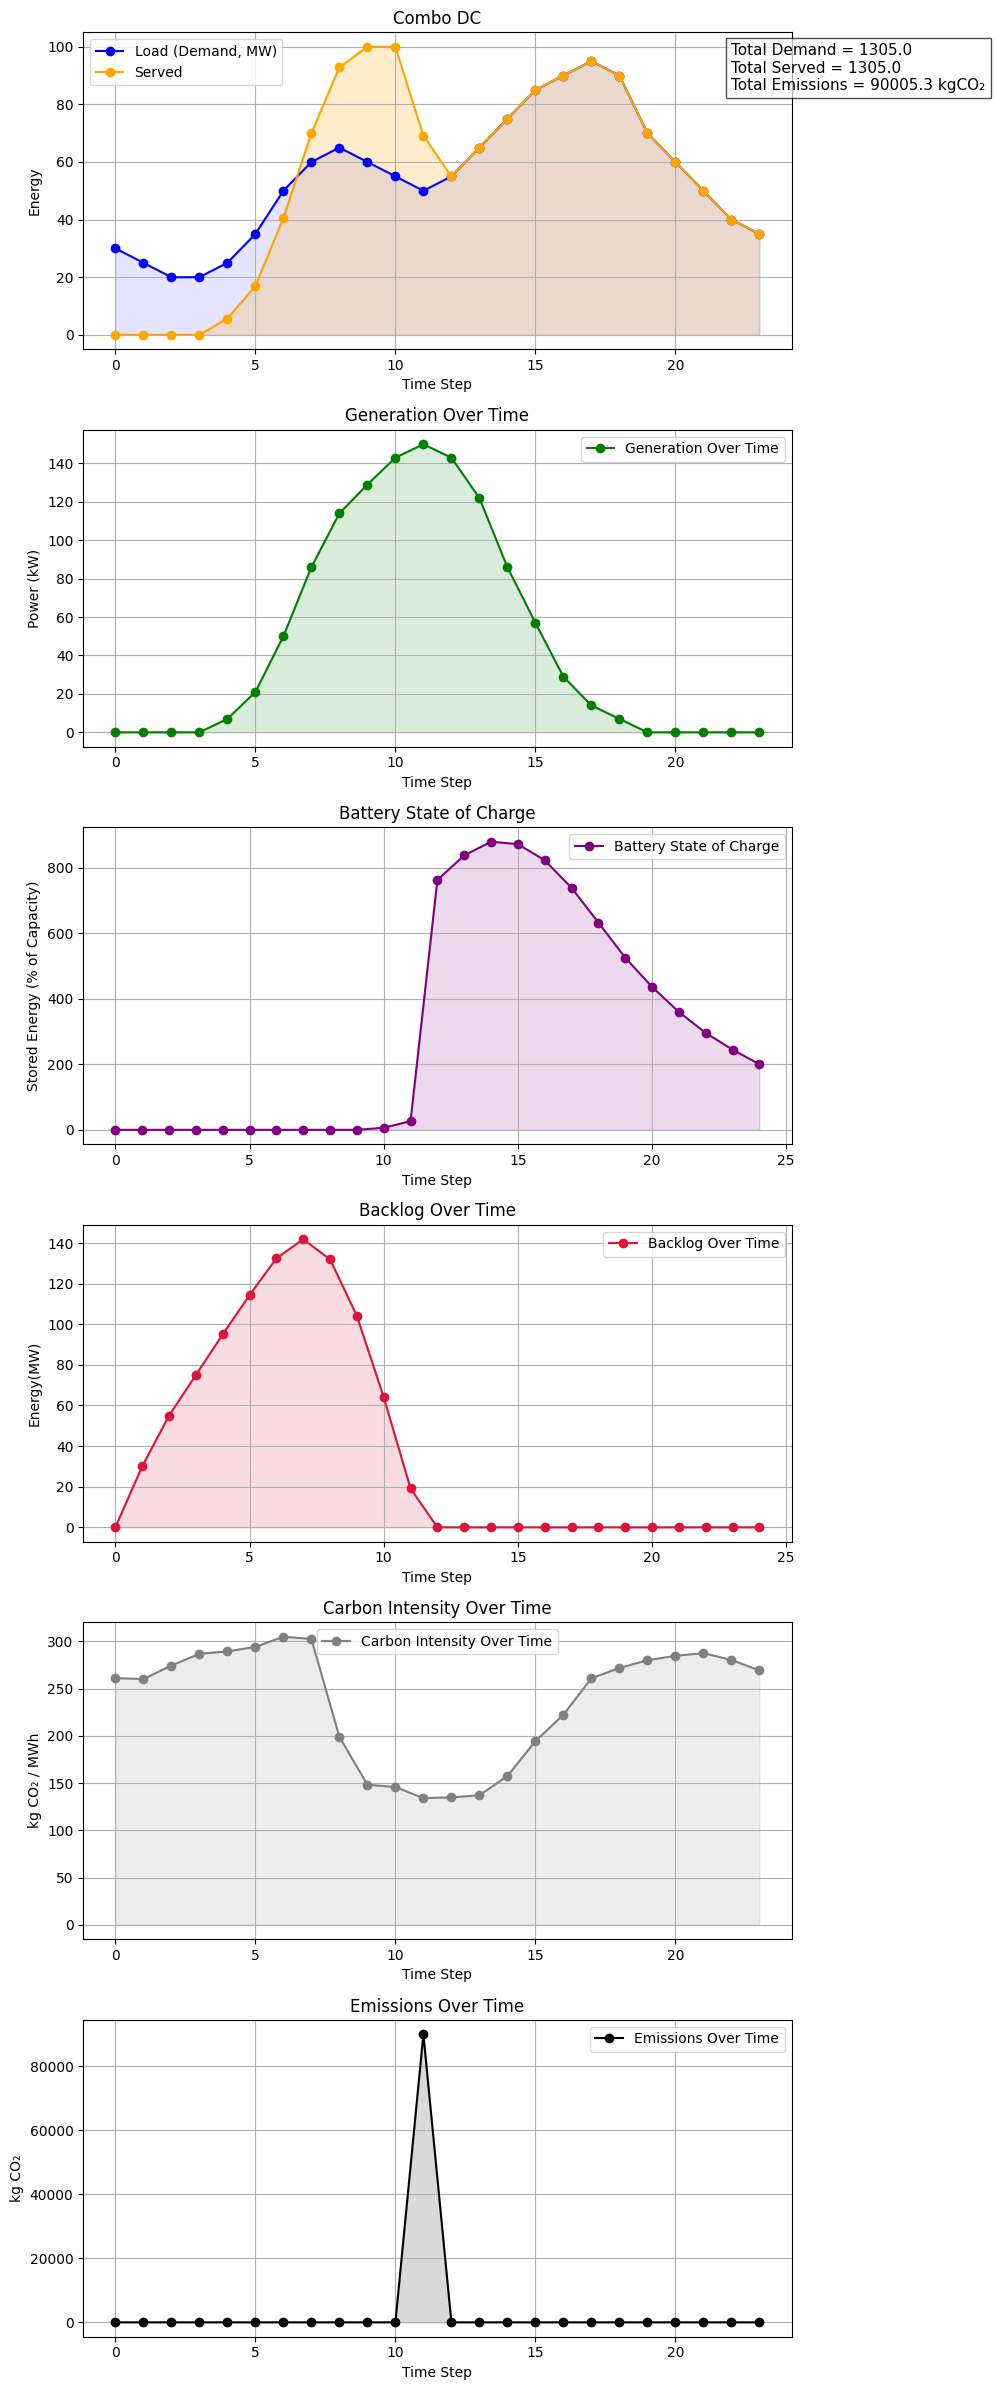

In [34]:
# Parameters
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = 1000 # float("inf") # or switch to actual computing limit
# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
L = [
    30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 
    55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
]  # Computational Load sum = 1400
G = [
     0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
   143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
]  #Renewable Generation sum = 1526

T = len(G)


C = shift_from_utc(Carbon_intensity[:T], 8)  # Shift to PST (UTC-8)

hours = np.arange(T)             
T_ref, COP_ref = 25.0, 4.0
T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m3 = gp.Model("Cooling + Grid + Storage + Renewables Optimal Scheduling")
m3.setParam("OutputFlag",0)

u_g = m3.addVars(T,name= "u_g",lb=0) # power associated with grid use
u_r = m3.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m3.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
s_charge_g = m3.addVars(T,name="s_charge_g",lb=0) # charge associated with grid
s_discharge = m3.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m3.addVars(T+1,name="x",lb=0) # Backlog
c = m3.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m3.addVars(T, name="P_chiller", lb=0) # cooling load
u = m3.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m3.addConstr(x[0]==0,"initial backlog")
m3.addConstr(c[0]==0,"inital storage")

#Terminal Conditions
m3.addConstr(c[T] >= 200, "terminal_storage")
m3.addConstr(x[T] <= x[0], "terminal_backlog") 

# Dynamics and constraints
m3.addConstrs((c[t+1] == c[t] + s_charge_r[t] + s_charge_g[t] - s_discharge[t] for t in range(T)), name="soc_update")
m3.addConstrs((c[t+1] <= battery_limit for t in range(T)), name="storage_capacity")
m3.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name="max_discharge")
m3.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m3.addConstrs((u[t] <= 100 for t in range(T)),name="compute_limit")
m3.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m3.addConstrs((u_r[t] + s_charge_r[t] == G[t] for t in range(T)),name="renewables_balance")
m3.addConstrs((u_g[t] + u_r[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_r[t] + s_charge_g[t] for t in range(T)), name="energy_balance")


m3.setObjective(gp.quicksum(u_g[t]*C[t] + r*x[t] for t in range(T)), GRB.MINIMIZE)
m3.optimize()


if m3.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 3:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    served_3 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_3 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_3 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_3 = [u_g[t].X * C[t] for t in range(T)]

    plot_results("Combo DC", served_3, soc=soc_3, second_plot=True,backlog = backlog_3, carbon_intensity=C, emissions=emissions_3)





# Final implementation (multiday/ full year simulation babyyyyy)

According to NREL's ATB (Annual Technology Baseline) https://atb.nrel.gov/electricity/2024/land-based_wind or check Trent's data set
- CAPEX Solar = $1482/KWh
- CAPEX Wind = $1665/KWh
- CAPEX Storage = $2100/KWh 
- Neglecting O&M (Operation and Maintenance)
- Efficiency factors can be found on the same website as well.


# Scenario 12 WHR (if time allows)